In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from tqdm import tqdm
from scipy import stats
from geolite2 import geolite2 
import string
%config InlineBackend.figure_format = 'retina' 

### Token flow

The goal of this notebook is to map token flow between addresses in the network. This notebook assumes that:
1. the actor relationship mining pipeline is successfully run (`main.py` produces the file `data/output.csv`)
2. user has a lookup table between miner IDs and addresses
3. user has a list of recent transactions

To generate (2) save the output of `select distinct id, address from id_addresses` (Lily schema) to a file.

To generate (3) save the output of `select * from parsed_messages where height > 22984802122800 and method='Send'` to a file.

In [188]:
worker_lookup_df = pd.read_csv('../data/worker_relationship_jun_20.csv', index_col=[0])

In [140]:
relationship_df = pd.read_csv('../data/output.csv', index_col=[0])
id_address_df = pd.read_csv('../data/id_lookup.csv', index_col=[0])
message_df = pd.read_csv('../data/recent_send_messages.csv', index_col=[0])

/Users/beng/miniforge3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### 0. Entity ID

As a starting point, we can use the pipeline output to establish an entity ID for every actor. This entity consists of workers, miners and owners. In the following we assemble two dicts / hash maps that assign an entity number and a country to every (or rather most) actors that we see.

In [141]:
entity_dict = {}
entity_location_dict = {}
for i in range(len(relationship_df)):
    
    # Convert the associated nodes into a list that we can iterate across
    nodes_in_entity = relationship_df.associated_nodes[i][1:-1].split(',')
    nodes_in_entity = [''.join(e for e in nie if e.isalnum()) for nie in nodes_in_entity]
    current_country = relationship_df.mode_country[i]

    for node in nodes_in_entity:
        entity_dict[node] = i
        entity_location_dict[node] = current_country

As an example

In [142]:
entity_dict['f01080779'], entity_location_dict['f01080779']

(0, 'CN')

### 1. Convert addresses to IDs for lookup

The messages use raw addresses, but our relationship list uses IDs. We therefore join on the ID-address lookup (2) so that every message has both addresses and IDs.

In [143]:
df = pd.merge(message_df, id_address_df, left_on = 'from_address', right_on='address')
df = df.rename(columns={'id': 'from_id'})
df = pd.merge(df, id_address_df, left_on = 'to_address', right_on='address')
df = df.rename(columns={'id': 'to_id'}).drop(columns=['address_x', 'address_y', 'height_in_month', 'etl_ts', 'cid'])
df.value = pd.to_numeric(df.value, errors='coerce')
df.value = df['value'] / 1e18

### 2. Map IDs to entities and countries

In [144]:
df['from_entity'] = df['from_id'].map(entity_dict).fillna('Unknown')
df['to_entity'] = df['from_id'].map(entity_dict).fillna('Unknown')
df['from_country'] = df['from_id'].map(entity_location_dict).fillna('Unknown')
df['to_country'] = df['from_id'].map(entity_location_dict).fillna('Unknown')

### 3. Generate a graph

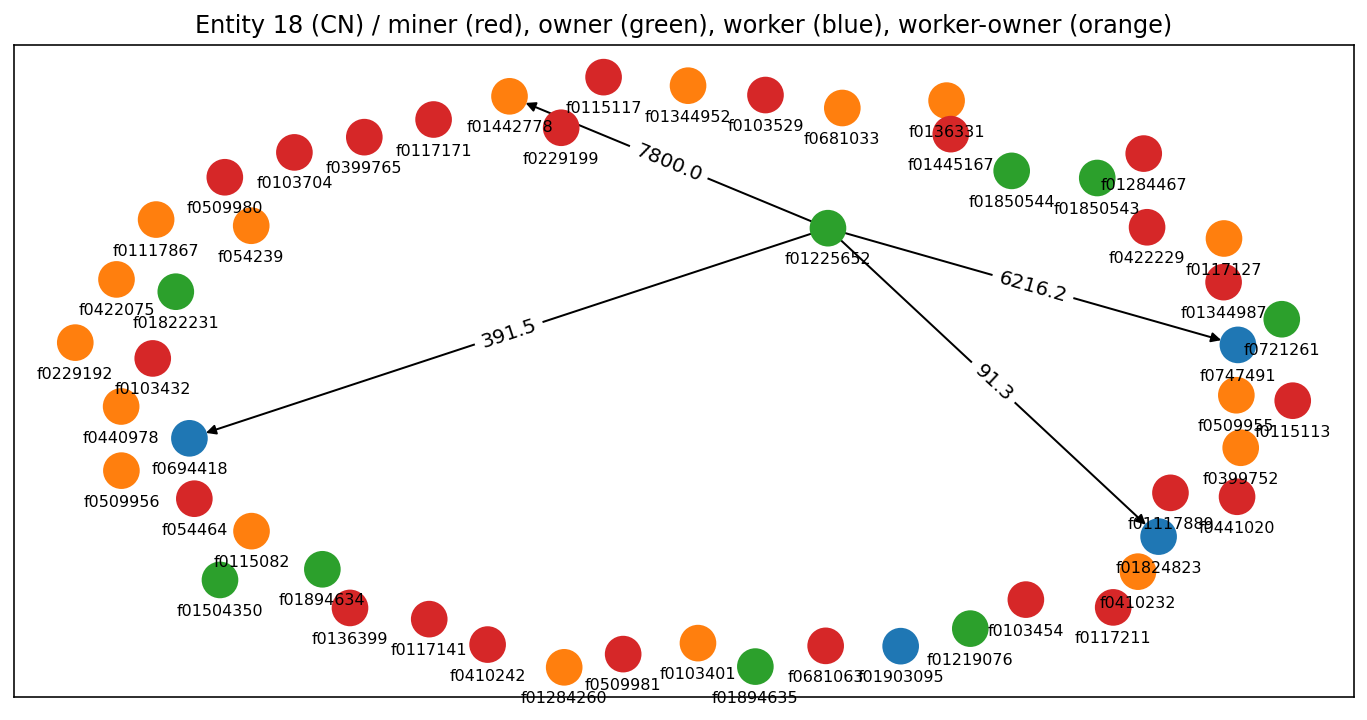

In [250]:
entity_idx = 18
flows = df[df.from_entity == entity_idx][['from_id', 'to_id', 'value']].groupby(['from_id', 'to_id']).sum()

all_nodes_in_selected_entity = relationship_df.associated_nodes[entity_idx][1:-1].split(',')
all_nodes_in_selected_entity = [''.join(e for e in nie if e.isalnum()) for nie in all_nodes_in_selected_entity]

G = nx.DiGraph()
G.add_nodes_from(all_nodes_in_selected_entity)

for i in range(len(flows)):
    weight = np.round(flows.iloc[i].value, 1)
    from_id, to_id = flows.iloc[i].name
    if (from_id, to_id) in G.edges():
        # If the edge already exists, add to the edge
        current_weight = list(G.edges().data())[i][-1]['weight']
        G.add_edge(from_id, to_id, weight=current_weight + weight)
    else: # If the edge doesn't exist, just add the weight
        G.add_edge(from_id, to_id, weight=weight)

color_map = []
for node in G.nodes:
    if node in worker_lookup_df.miner_id.values:
        color_map.append('C3')
    else:
        if (node in worker_lookup_df.owner_id.values) and (node in worker_lookup_df.worker_id.values):
                color_map.append('C1')
        else:
            if node in worker_lookup_df.owner_id.values:
                color_map.append('C2')
            else:
                color_map.append('C0')

plt.figure(figsize=(12,6))
pos = nx.spring_layout(G)
grafo_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, node_color=color_map)
nx.draw_networkx_edges(G, pos)
edges_label = nx.draw_networkx_edge_labels(G, pos, edge_labels = grafo_labels)

for node, (x, y) in pos.items():
    plt.text(x, y-0.1, node, fontsize=8, ha='center', va='center')

try:
    plt.title('Entity %s (%s) / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx, stats.mode(df[df.from_entity == entity_idx].from_country.unique()).mode[0]))
except:    
    plt.title('Entity %s / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx))

A general observation is that token generally only flows from owners to workers. 

Interestingly, there is no flow between the entities. There should be, in principle, some activity between a specific organisation and, say, an exchange. 

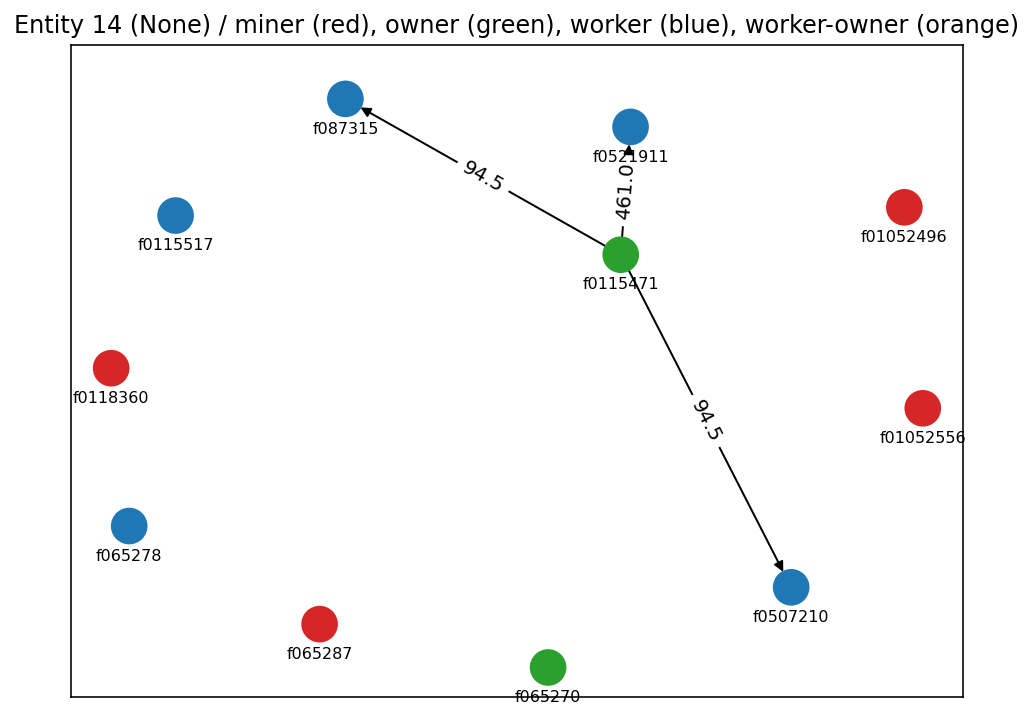

In [271]:
entity_idx = 14
flows = df[df.from_entity == entity_idx][['from_id', 'to_id', 'value']].groupby(['from_id', 'to_id']).sum()

all_nodes_in_selected_entity = relationship_df.associated_nodes[entity_idx][1:-1].split(',')
all_nodes_in_selected_entity = [''.join(e for e in nie if e.isalnum()) for nie in all_nodes_in_selected_entity]

G = nx.DiGraph()
G.add_nodes_from(all_nodes_in_selected_entity)

for i in range(len(flows)):
    weight = np.round(flows.iloc[i].value, 1)
    from_id, to_id = flows.iloc[i].name
    if (from_id, to_id) in G.edges():
        # If the edge already exists, add to the edge
        current_weight = list(G.edges().data())[i][-1]['weight']
        G.add_edge(from_id, to_id, weight=current_weight + weight)
    else: # If the edge doesn't exist, just add the weight
        G.add_edge(from_id, to_id, weight=weight)

color_map = []
for node in G.nodes:
    if node in worker_lookup_df.miner_id.values:
        color_map.append('C3')
    else:
        if (node in worker_lookup_df.owner_id.values) and (node in worker_lookup_df.worker_id.values):
                color_map.append('C1')
        else:
            if node in worker_lookup_df.owner_id.values:
                color_map.append('C2')
            else:
                color_map.append('C0')

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G)
grafo_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, node_color=color_map)
nx.draw_networkx_edges(G, pos)
edges_label = nx.draw_networkx_edge_labels(G, pos, edge_labels = grafo_labels)

for node, (x, y) in pos.items():
    plt.text(x, y-0.1, node, fontsize=8, ha='center', va='center')

try:
    plt.title('Entity %s (%s) / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx, stats.mode(df[df.from_entity == entity_idx].from_country.unique()).mode[0]))
except:    
    plt.title('Entity %s / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx))

### An exchange


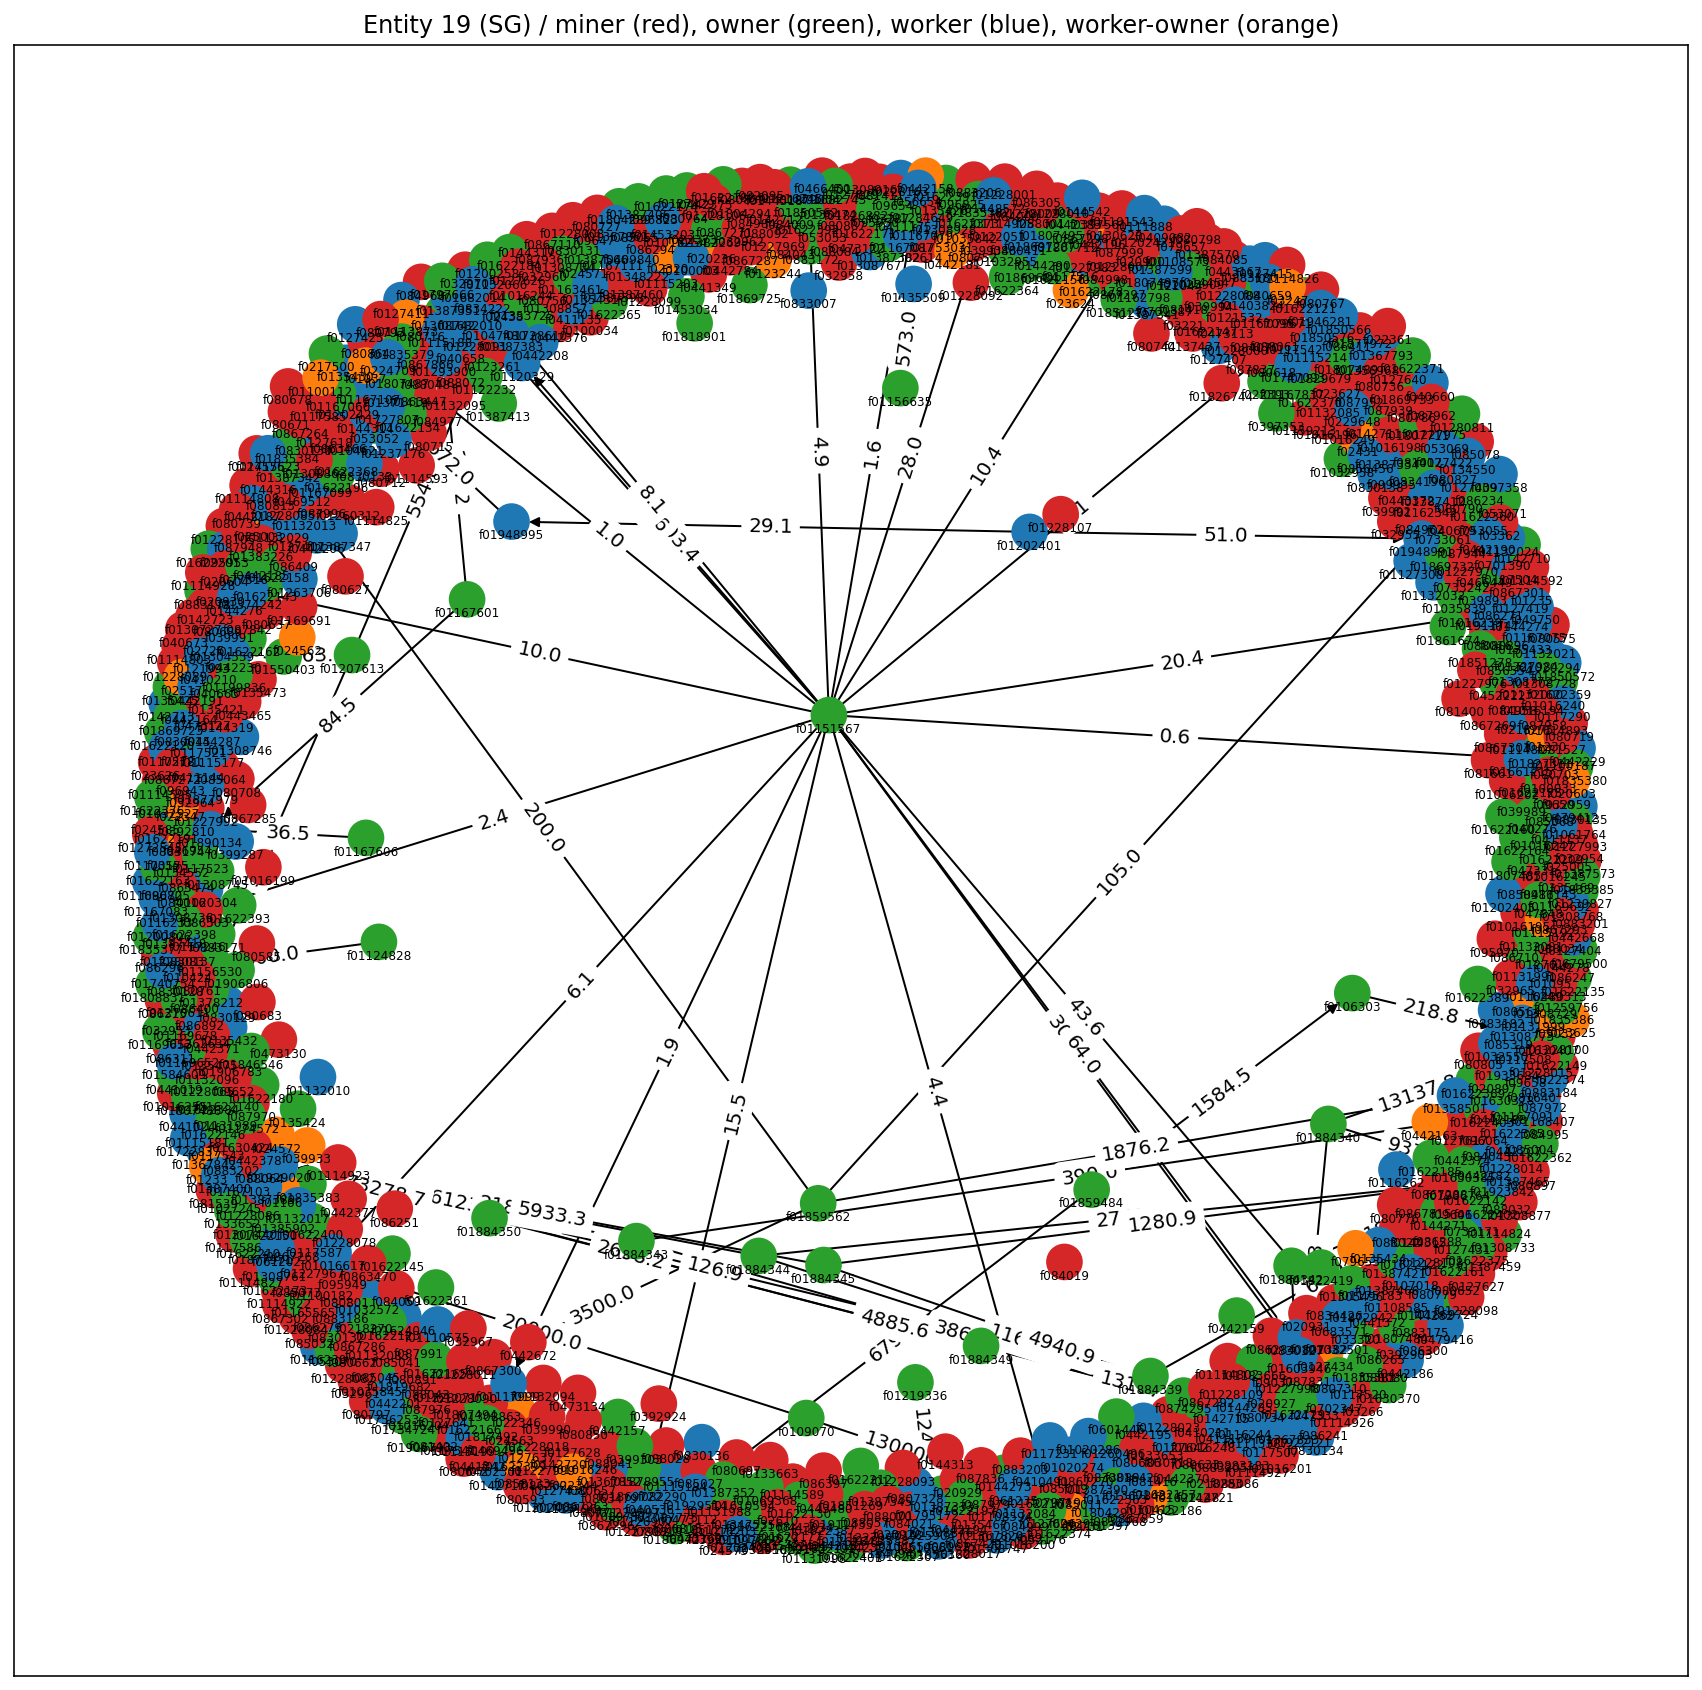

In [278]:
entity_idx = 19
flows = df[df.from_entity == entity_idx][['from_id', 'to_id', 'value']].groupby(['from_id', 'to_id']).sum()

all_nodes_in_selected_entity = relationship_df.associated_nodes[entity_idx][1:-1].split(',')
all_nodes_in_selected_entity = [''.join(e for e in nie if e.isalnum()) for nie in all_nodes_in_selected_entity]

G = nx.DiGraph()
G.add_nodes_from(all_nodes_in_selected_entity)

for i in range(len(flows)):
    weight = np.round(flows.iloc[i].value, 1)
    from_id, to_id = flows.iloc[i].name
    if (from_id, to_id) in G.edges():
        # If the edge already exists, add to the edge
        current_weight = list(G.edges().data())[i][-1]['weight']
        G.add_edge(from_id, to_id, weight=current_weight + weight)
    else: # If the edge doesn't exist, just add the weight
        G.add_edge(from_id, to_id, weight=weight)

color_map = []
for node in G.nodes:
    if node in worker_lookup_df.miner_id.values:
        color_map.append('C3')
    else:
        if (node in worker_lookup_df.owner_id.values) and (node in worker_lookup_df.worker_id.values):
                color_map.append('C1')
        else:
            if node in worker_lookup_df.owner_id.values:
                color_map.append('C2')
            else:
                color_map.append('C0')

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
grafo_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, node_color=color_map)
nx.draw_networkx_edges(G, pos)
edges_label = nx.draw_networkx_edge_labels(G, pos, edge_labels = grafo_labels)

for node, (x, y) in pos.items():
    plt.text(x, y-0.02, node, fontsize=6, ha='center', va='center')

try:
    plt.title('Entity %s (%s) / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx, stats.mode(df[df.from_entity == entity_idx].from_country.unique()).mode[0]))
except:    
    plt.title('Entity %s / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx))

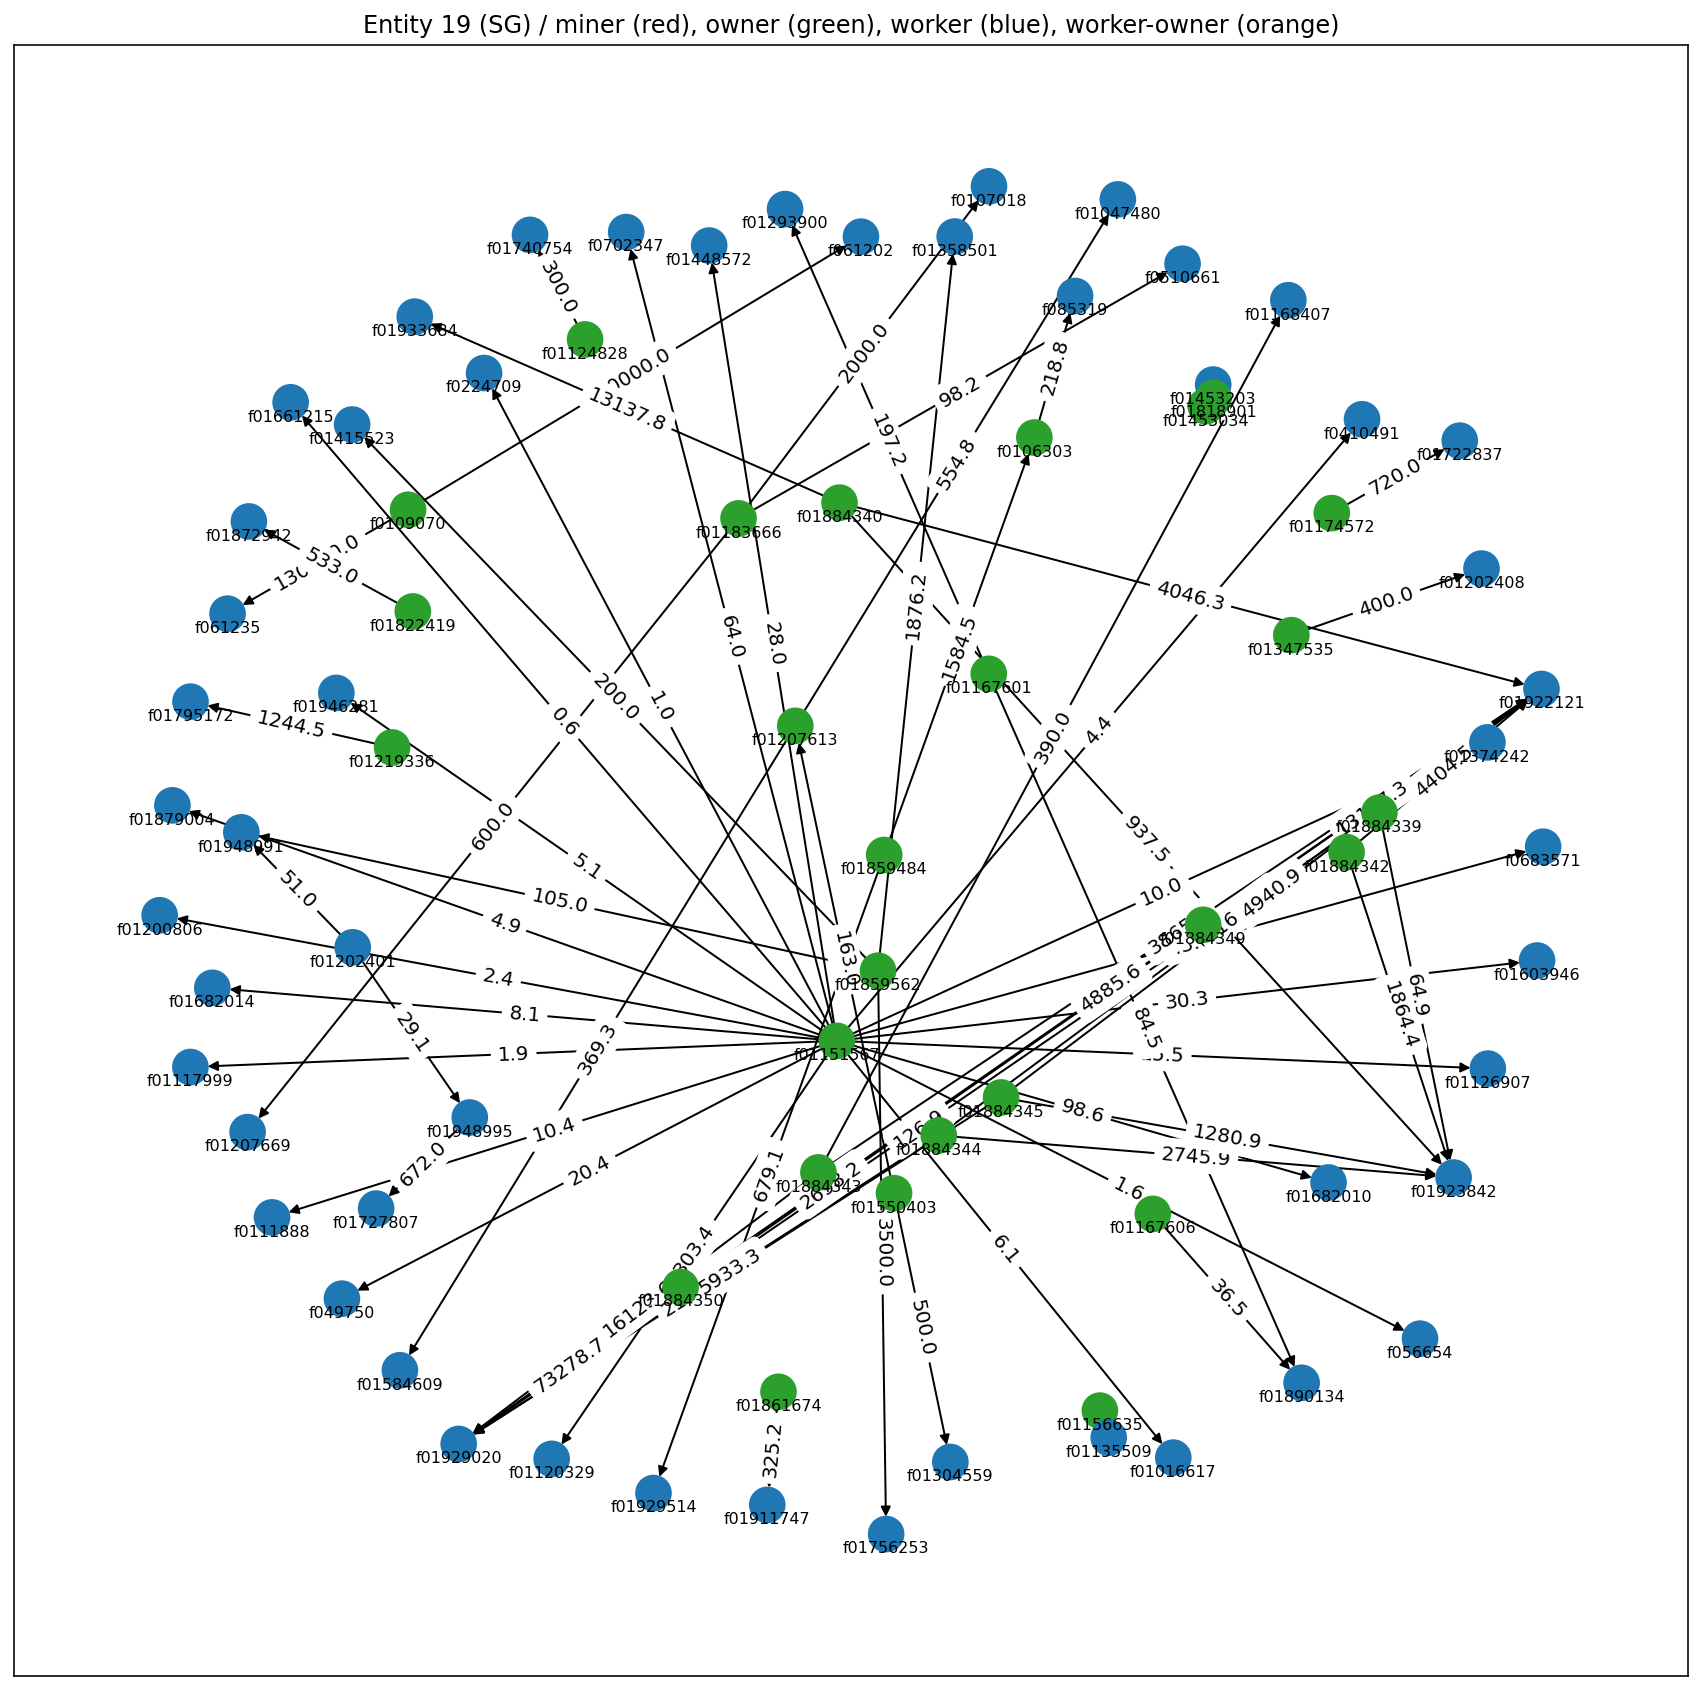

In [282]:
entity_idx = 19
flows = df[df.from_entity == entity_idx][['from_id', 'to_id', 'value']].groupby(['from_id', 'to_id']).sum()

all_nodes_in_selected_entity = relationship_df.associated_nodes[entity_idx][1:-1].split(',')
all_nodes_in_selected_entity = [''.join(e for e in nie if e.isalnum()) for nie in all_nodes_in_selected_entity]

G = nx.DiGraph()
# G.add_nodes_from(all_nodes_in_selected_entity)

for i in range(len(flows)):
    weight = np.round(flows.iloc[i].value, 1)
    from_id, to_id = flows.iloc[i].name
    if (from_id, to_id) in G.edges():
        # If the edge already exists, add to the edge
        current_weight = list(G.edges().data())[i][-1]['weight']
        G.add_edge(from_id, to_id, weight=current_weight + weight)
    else: # If the edge doesn't exist, just add the weight
        G.add_edge(from_id, to_id, weight=weight)

color_map = []
for node in G.nodes:
    if node in worker_lookup_df.miner_id.values:
        color_map.append('C3')
    else:
        if (node in worker_lookup_df.owner_id.values) and (node in worker_lookup_df.worker_id.values):
                color_map.append('C1')
        else:
            if node in worker_lookup_df.owner_id.values:
                color_map.append('C2')
            else:
                color_map.append('C0')

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
grafo_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, node_color=color_map)
nx.draw_networkx_edges(G, pos)
edges_label = nx.draw_networkx_edge_labels(G, pos, edge_labels = grafo_labels)

for node, (x, y) in pos.items():
    plt.text(x, y-0.02, node, fontsize=8, ha='center', va='center')

try:
    plt.title('Entity %s (%s) / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx, stats.mode(df[df.from_entity == entity_idx].from_country.unique()).mode[0]))
except:    
    plt.title('Entity %s / miner (red), owner (green), worker (blue), worker-owner (orange)' % (entity_idx))

Here we have an example of an extremely busy network - likely a lender or an exchange. One owner node `f01151567` in particular is responsible for disbursing tokens to many worker nodes. 

In [284]:
id_address_df[id_address_df.id == 'f01151567']

,id,address
224634,f01151567,f1vgb4zsj5zn3wlwivdmmz46njjpukjcl2s3pskka


### Who were the top senders and receivers

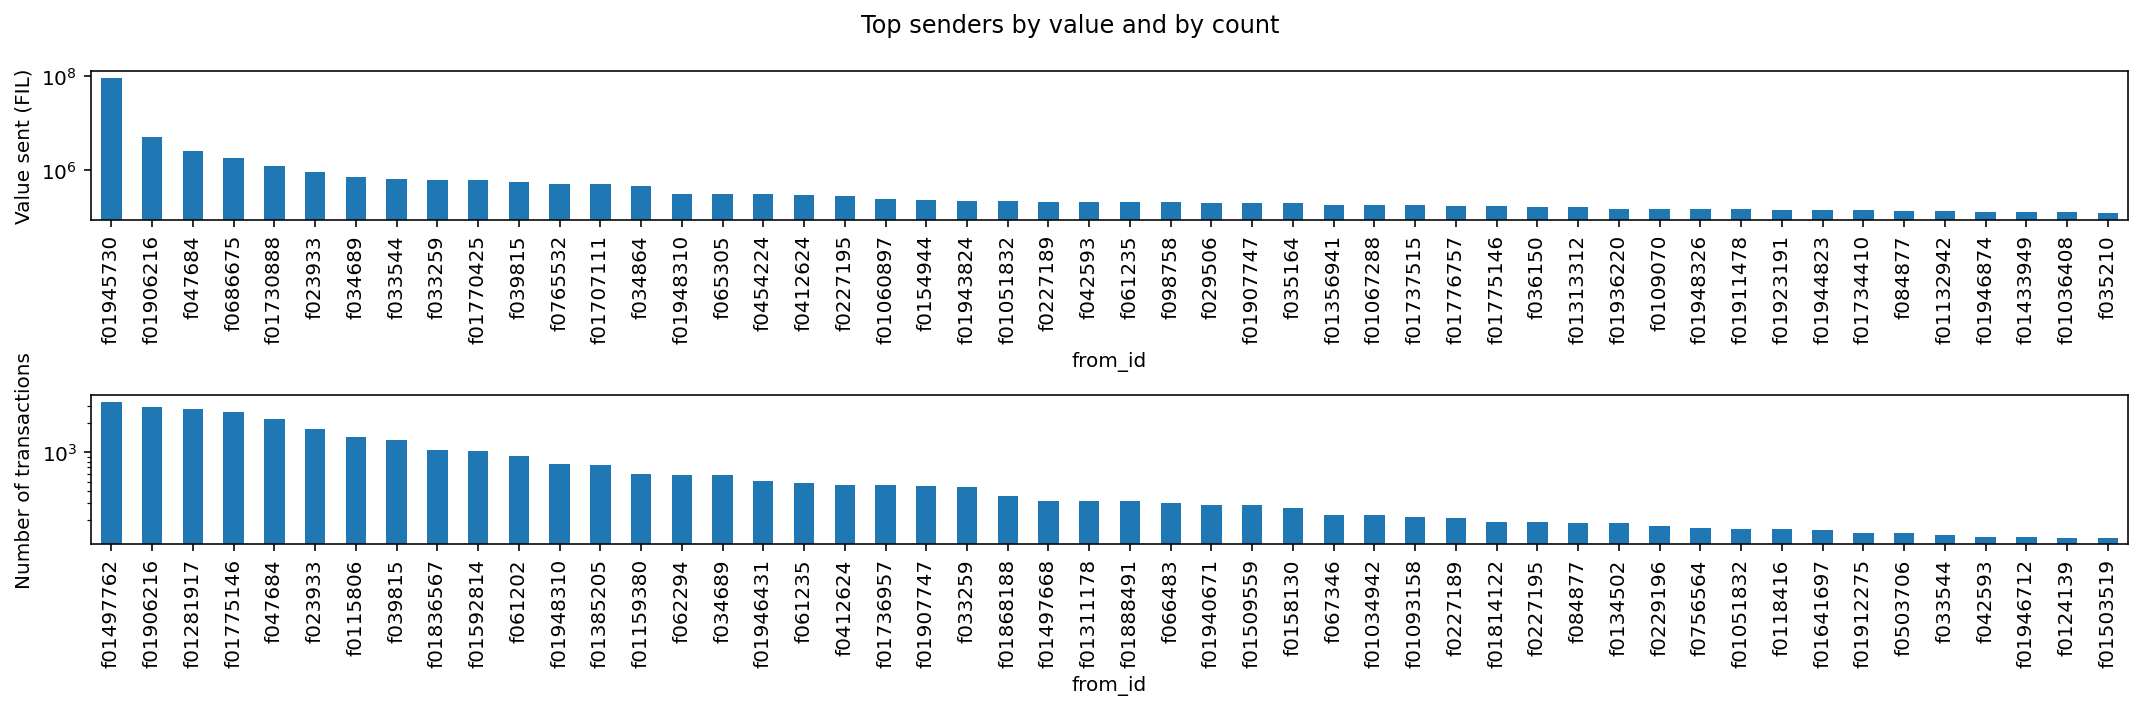

In [302]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,5))
df.groupby(['from_id']).sum()['value'].sort_values(ascending=False).iloc[0:50].plot(kind='bar',ax=ax1)
ax1.set_yscale('log')
df.groupby(['from_id']).count()['value'].sort_values(ascending=False).iloc[0:50].plot(kind='bar',ax=ax2)
ax2.set_yscale('log')
ax1.set_ylabel('Value sent (FIL)')
ax2.set_ylabel('Number of transactions')
plt.suptitle('Top senders by value and by count')
plt.tight_layout()

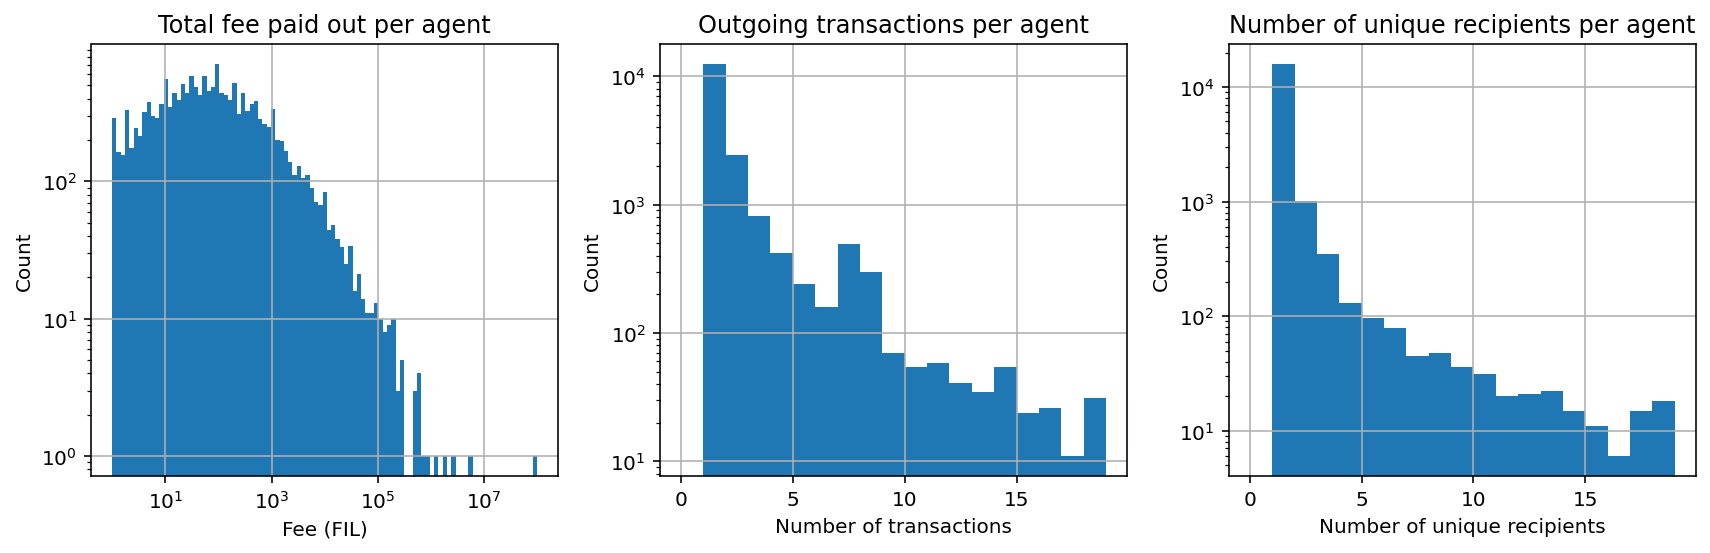

In [339]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
df.groupby(['from_id']).sum()['value'].hist(bins=np.logspace(0,8,100), ax=ax1)
ax1.set_xscale('log')
ax1.set_title('Total fee paid out per agent')
ax1.set_xlabel('Fee (FIL)')
ax1.set_ylabel('Count')
ax1.set_yscale('log')

df.groupby(['from_id']).count()['value'].hist(bins=np.arange(20), ax=ax2)
# ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Outgoing transactions per agent')
ax2.set_xlabel('Number of transactions')
ax2.set_ylabel('Count')

df.groupby(['from_id']).nunique()['to_id'].hist(ax=ax3, bins=np.arange(20))
ax3.set_yscale('log')
ax3.set_title('Number of unique recipients per agent')
ax3.set_xlabel('Number of unique recipients')
ax3.set_ylabel('Count')
plt.tight_layout()

For small fees paid out there is a bell-shaped distribution but a small number of agents (as exemplified by the power law decay for fee exceeding 1,000 FIL) paying out a lot. I think this could be a reasonable definition for an important entity (e.g. lender or exchange account). 

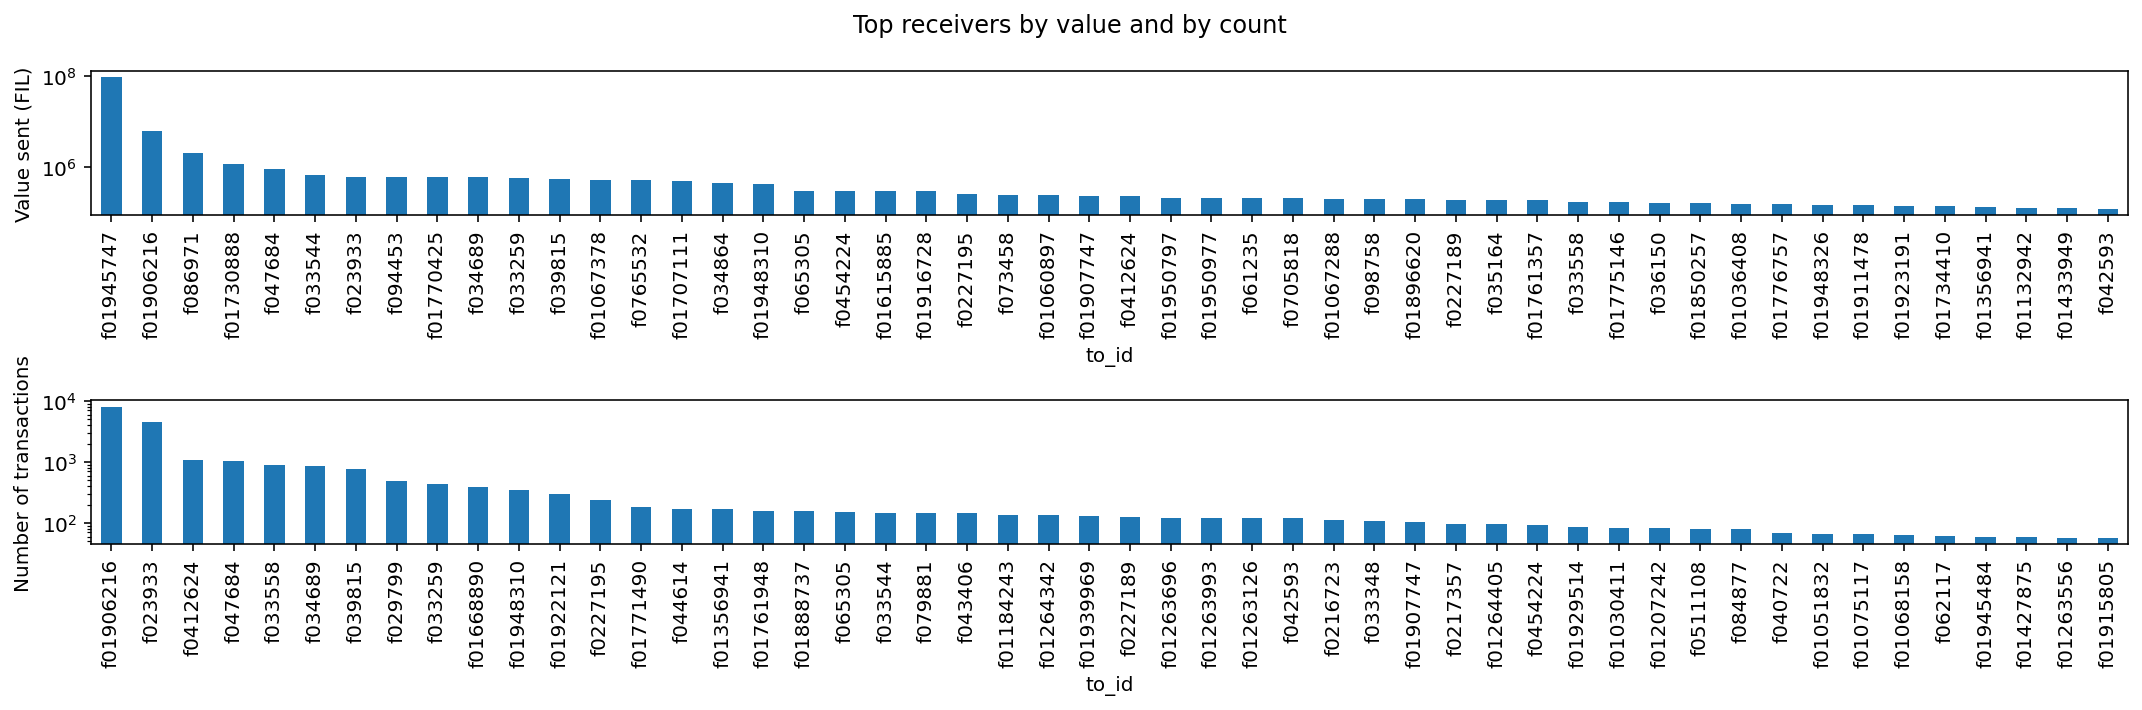

In [323]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,5))
df.groupby(['to_id']).sum()['value'].sort_values(ascending=False).iloc[0:50].plot(kind='bar',ax=ax1)
ax1.set_yscale('log')
df.groupby(['to_id']).count()['value'].sort_values(ascending=False).iloc[0:50].plot(kind='bar',ax=ax2)
ax2.set_yscale('log')
ax1.set_ylabel('Value sent (FIL)')
ax2.set_ylabel('Number of transactions')
plt.suptitle('Top receivers by value and by count')
plt.tight_layout()

Text(0, 0.5, 'Count')

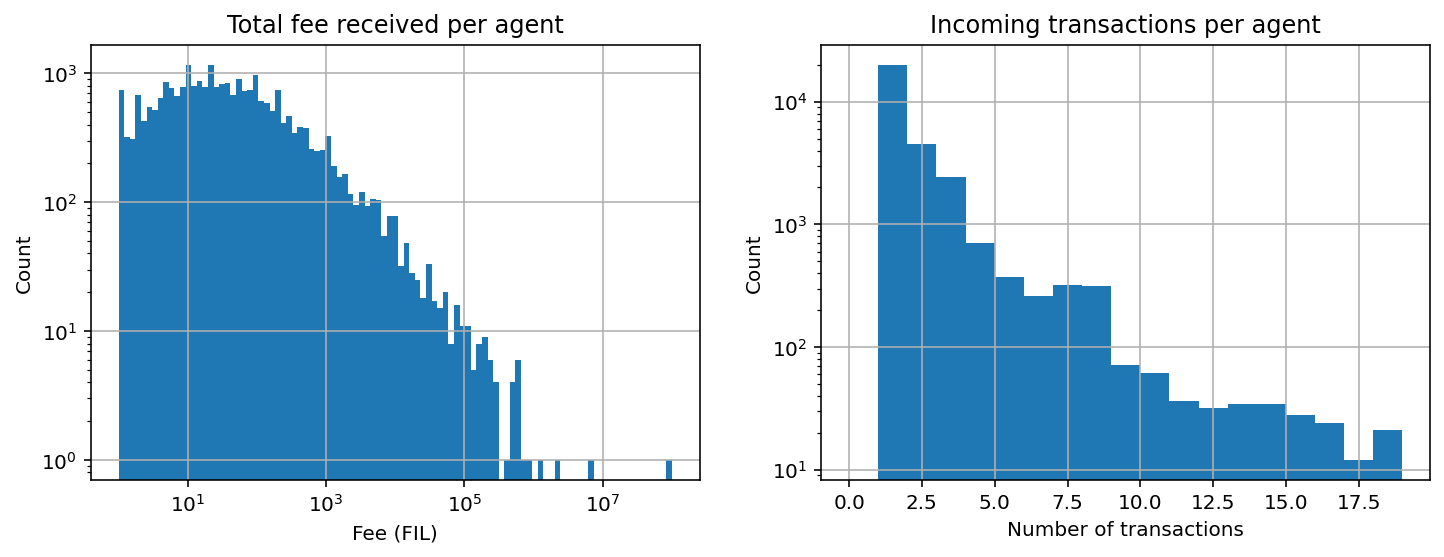

In [327]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
df.groupby(['to_id']).sum()['value'].hist(bins=np.logspace(0,8,100), ax=ax1)
ax1.set_xscale('log')
ax1.set_title('Total fee received per agent')
ax1.set_xlabel('Fee (FIL)')
ax1.set_ylabel('Count')
ax1.set_yscale('log')

df.groupby(['to_id']).count()['value'].hist(bins=np.arange(20), ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Incoming transactions per agent')
ax2.set_xlabel('Number of transactions')
ax2.set_ylabel('Count')


Something very similar occurs for agents who receive money. There are some agents that receive a great deal of money, and again the power law distribution is fairly similar. 